In [1]:
!pip install transformers
!pip install sentencepiece
!pip install segtok
!pip install vaderSentiment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Global Variables

In [3]:
import os
import sys

from pathlib import Path
import json
import torch
import pandas as pd
import random

from keras.preprocessing.sequence import pad_sequences

from segtok import tokenizer

In [4]:
ROOT_FOLDER = Path("/content/drive/My Drive/cs182_final_project/cs182-nlp (master)")
DATA_FOLDER = ROOT_FOLDER / "yelp_dataset"
STARTER_DATA_FOLDER = ROOT_FOLDER / "starter"

In [5]:
sys.path.append(ROOT_FOLDER)

#Data Preprocessing

In [6]:
def load_json(file_path, filter_function=lambda x: True):
  """
  file_path - path of the file to read from
  filter_function - A function that returns True to ADD the data line
  """
  result = []

  try:
    with open(file_path, "r") as f: # or ROOT_FOLDER / file_path
      for line in f:
        json_line = json.loads(line)
        if not filter_function(json_line):
          # Disallow via opposite of allow
          continue
        result.append(json_line) # each line is one data point dictionary
    # return pd.DataFrame.from_records(result)
    return result

  except IOError:
    print(f"cannot open {file_path}")
    return None

# Currently unused
def larger_yelp_filter(json_ref):
  review_id_set = set([review["review_id"].strip() for review in json_ref])
  print(len(review_id_set))
  review_id_tracker = {} # For debugging purposes, giving ID and Number of Times seen
  count = 0
  def filter_function(json_data):
    nonlocal count
    review_id = json_data["review_id"].strip()
    if review_id in review_id_set:
      review_id_tracker[review_id] = review_id_tracker.get(review_id, 0) + 1
      count += 1
      if count % 10000 == 0:
        print(count, count / len(review_id_set))
      if review_id_tracker[review_id] >= 2:
        print("Duplicate", review_id, review_id_tracker[review_id])
      return True
    return False
  def larger_yelp_filter_viewer():
    return review_id_set, review_id_tracker
  return filter_function, larger_yelp_filter_viewer

In [7]:
# load yelp data
yelp_reviews_starter = load_json(STARTER_DATA_FOLDER / "yelp_review_training_dataset.jsonl")

In [8]:
print(len(yelp_reviews_starter))

533581


In [9]:
# Here's what one data point look like
def give_first_line_data(data):
  if data is None:
    return None
  return data[0]
print(give_first_line_data(yelp_reviews_starter))

{'review_id': 'Q1sbwvVQXV2734tPgoKj4Q', 'text': 'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.', 'stars': 1.0}


In [10]:
# turn into a dataFrames
STARTER = pd.DataFrame.from_records(yelp_reviews_starter)
display(STARTER)

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1.0
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5.0
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5.0
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5.0
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1.0
...,...,...,...
533576,2vQO_kmSr6YPBrR8GH_FPA,Dr Young and her assistants take obvious pride...,5.0
533577,DUdLTGVpgsi0sv_g4A5ITQ,We started our 20 month of daughter here on an...,5.0
533578,AKGELpRNTTXajuZHbPxdJg,"First of all, they are supposed to open at 9:0...",2.0
533579,ghYZM7lqzjej05I_T3vYyA,It's not often that you visit a company and th...,5.0


#Helper Functions

In [11]:
def pad_sequence(numerized, pad_index, to_length):
    pad = numerized[:to_length]
    padded = pad + [pad_index] * (to_length - len(pad))
    mask = [w != pad_index for w in padded]
    return padded, mask

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
batch_to_torch = lambda b_in, b_targets, b_mask: (torch.LongTensor(b_in),
                                                  torch.LongTensor(b_in),
                                                  torch.FloatTensor(b_mask))

In [14]:
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

#Model

In [15]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'xlnet-base-cased')
model.to(device)
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'xlnet-base-cased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


In [16]:
def tokenize_review(review):
  encodings = tokenizer.encode_plus(review, add_special_tokens=True,
                                    max_length=256,
                                    return_token_type_ids=False,
                                    return_attention_mask=False,
                                    truncation=True,
                                    pad_to_max_length=False)
  return encodings.get("input_ids", [])

In [17]:
tokenize_review("I love this grub!")

[35, 564, 52, 17, 10862, 508, 136, 4, 3]

In [18]:
def process_reviews(datatable, indices):
  encoded_reviews = []
  encoded_reviews_mask = []
  reviews_to_process = datatable[["text", "stars"]]
  reviews_to_process = reviews_to_process.iloc[indices]
  # if max_count is not None:
  #   reviews_to_process = reviews_to_process[:max_count]

  for review_text in reviews_to_process["text"]:
    numerized = tokenize_review(review_text)
    padded, mask = pad_sequence(numerized, 0, 256)
    encoded_reviews.append(padded)
    encoded_reviews_mask.append(mask)

  torch_encoded_reviews, torch_encoded_reviews_target, torch_encoded_reviews_mask = batch_to_torch(encoded_reviews, reviews_to_process["stars"], encoded_reviews_mask)
  return torch_encoded_reviews, torch_encoded_reviews_target, torch_encoded_reviews_mask

In [19]:
# torch_encoded_reviews, torch_encoded_reviews_target, torch_encoded_reviews_mask = process_reviews(STARTER, max_count=100)

In [20]:
# model.train()
# torch_encoded_reviews, torch_encoded_reviews_target, torch_encoded_reviews_mask = list_to_device((torch_encoded_reviews, torch_encoded_reviews_target, torch_encoded_reviews_mask))
# model(input_ids=torch_encoded_reviews, attention_mask=torch_encoded_reviews_mask, labels=torch_encoded_reviews_target)

In [21]:
model.train()
losses = []
accuracies = []

import tqdm
import numpy as np

# model.to(device)

batch_size = 32
epochs = 20

In [22]:
for epoch in range(epochs):
    indices = np.random.permutation(range(len(STARTER)))
    t = tqdm.notebook.tqdm(range(0,(len(STARTER)//batch_size)+1))
    for i in t:
      # Here is how you obtain a batch:
      batch = process_reviews(STARTER, indices[i*batch_size:(i+1)*batch_size])
      (batch_input, batch_target, batch_target_mask) = batch_to_torch(*batch)
      for item in (batch_input, batch_target, batch_target_mask):
        print(item.size())
      (batch_input, batch_target, batch_target_mask) = list_to_device((batch_input, batch_target, batch_target_mask))
      
      prediction = model.forward(batch_input)
      loss = loss_fn(prediction, batch_target, batch_target_mask)
      losses.append(loss.item())
      accuracy = (th.eq(prediction.argmax(dim=2,keepdim=False),batch_target).float()*batch_target_mask).sum()/batch_target_mask.sum()
      accuracies.append(accuracy.item())
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if i % 100 == 0:
          batch_val = build_batch(d_valid, range(len(d_valid)))
          (batch_input_val, batch_target_val, batch_target_mask_val) = list_to_device(batch_to_torch(*batch_val))
          prediction_val = model.forward(batch_input_val)
          loss_val = loss_fn(prediction_val, batch_target_val, batch_target_mask_val)
          print("Evaluation set loss:", loss_val.item())
          print(f"Epoch: {epoch} Iteration: {i} Loss: {np.mean(losses[-10:])} Accuracy: {np.mean(accuracies[-10:])}")

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])


RuntimeError: ignored

#Playground

In [ ]:
# This is a cheap solution to stops any run all that reaches my Playground
hard_stop = input("Hard Stop here. Enter any key to allow passage.")

if len(hard_stop) == 0:
  raise Exception("Hard Stop")

Hard Stop here. Enter any key to allow passage.


Exception: ignored

In [ ]:
print(list(tokenize(STARTER["text"]))[:3])

In [13]:
import urllib.request
import io
import sentencepiece as spm
import re

In [13]:
# https://github.com/google/sentencepiece/tree/master/python

# Loads model from URL as iterator and stores the model to BytesIO.
model = io.BytesIO()
def starter_iterator():
  count = 0
  print(count)
  word_set = set()
  yield "#"
  for line in STARTER["text"].values:
    line = re.sub(r"[^a-zA-Z0-9' ]", " ", line)
    for subword in tokenizer.word_tokenizer(line.lower()):
      word_set.add(subword)
    if count % 10000 == 0 and count != 0:
      print(len(word_set))
      print(count)
      if (len(word_set) > 100000):
        print("END EARLY for debugging")
        return
    count += 1
    yield line.lower() + " # # #"

spm.SentencePieceTrainer.train(sentence_iterator=starter_iterator(), model_writer=model, vocab_size=32000)

0


RuntimeError: ignored

In [47]:
# Directly load the model from serialized model.
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
print(sp.encode('this is test'), sp.encode('this is test <pad>'))

[26, 21, 909] [26, 21, 909, 4, 8, 7, 9]


In [ ]:
# Serialize the model as file.
with open(STARTER_DATA_FOLDER / 'out.model', 'wb') as f:
  f.write(model.getvalue())

In [26]:
sp = spm.SentencePieceProcessor()
sp.Load(str(STARTER_DATA_FOLDER / 'out.model'))

# Directly load the model from serialized model.
print(sp.encode('this is test'), sp.encode('this is test <pad>'))

[22, 17, 914]


In [52]:
vocabs = [[sp.id_to_piece(id), id] for id in range(sp.get_piece_size())]
print(vocabs)

[['<unk>', 0], ['<s>', 1], ['</s>', 2], ['▁the', 3], ['▁', 4], ['▁and', 5], ['▁i', 6], ['pad', 7], ['<', 8], ['>', 9], ['▁to', 10], ['▁a', 11], ['s', 12], ["'", 13], ['▁was', 14], ['▁of', 15], ['▁it', 16], ['▁for', 17], ['ed', 18], ['▁my', 19], ['▁in', 20], ['▁is', 21], ['▁they', 22], ['▁that', 23], ['t', 24], ['▁with', 25], ['▁this', 26], ['▁you', 27], ['▁on', 28], ['▁have', 29], ['▁we', 30], ['▁not', 31], ['▁but', 32], ['▁me', 33], ['ing', 34], ['▁had', 35], ['ly', 36], ['▁are', 37], ['▁so', 38], ['▁at', 39], ['▁be', 40], ['▁very', 41], ['▁were', 42], ['▁he', 43], ['▁there', 44], ['▁she', 45], ['▁place', 46], ['▁as', 47], ['▁out', 48], ['▁great', 49], ['▁all', 50], ['▁time', 51], ['▁if', 52], ['d', 53], ['▁would', 54], ['▁when', 55], ['▁service', 56], ['▁from', 57], ['▁up', 58], ['▁get', 59], ['▁good', 60], ['▁an', 61], ['▁one', 62], ['▁their', 63], ['▁like', 64], ['▁just', 65], ['▁our', 66], ['▁back', 67], ['▁here', 68], ['▁will', 69], ['▁or', 70], ['▁them', 71], ['▁food', 72], ['▁w

In [16]:
def pad_sequence(numerized, pad_index, to_length):
    pad = numerized[:to_length]
    padded = pad + [pad_index] * (to_length - len(pad))
    mask = [w != pad_index for w in padded]
    return padded, mask

def get_pad_index(sp):
  for id in range(sp.get_piece_size()):
    if "#" == sp.id_to_piece(id):
      return id
  print("No pad index found")
  return None

In [15]:
pad_index = get_pad_index(sp)
text_length = 128
sp.pad_id()

NameError: ignored

In [14]:
encoded_reviews = [tokenizer.encode(rating) for rating in STARTER["text"][:100]]

In [17]:
padded_encoded_reviews = [pad_sequence(review, 0, 128) for review in encoded_reviews]

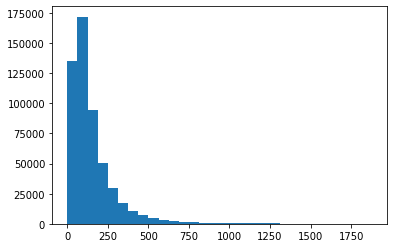

In [44]:
sizes = list(map(lambda x: len(x), encoded_reviews))

import matplotlib.pyplot as plt

plt.hist(sizes, bins=30)

plt.show()

In [18]:
torch_encoded_reviews = torch.LongTensor(padded_encoded_reviews)

In [ ]:
print(torch_encoded_reviews.size())
result = model.forward(input_ids=torch_encoded_reviews[:, 0, :], attention_mask=torch_encoded_reviews[:, 1, :])

torch.Size([100, 2, 128])


In [ ]:
print(result)

##Index Numerize the words

In [ ]:
def tokenize(data):
  """
  data - an iterable of sentences
  """
  token_set = set()
  i = 0
  for sentences in data:
    if i % 1000 == 0:
      print(i, end=", " if i % 15000 != 0 else "\n")
    tokenized = tokenizer.word_tokenizer(sentences.lower())
    for token in tokenized:
      token_set.add(token)
    i += 1
  return token_set

0
1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000
16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000
31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000
46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000, 54000, 55000, 56000, 57000, 58000, 59000, 60000
61000, 62000, 63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000, 72000, 73000, 74000, 75000
76000, 77000, 78000, 79000, 80000, 81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000, 90000
91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000, 99000, 100000, 101000, 102000, 103000, 104000, 105000
106000, 107000, 108000, 109000, 110000, 111000, 112000, 113000, 114000, 115000, 116000, 117000, 118000, 119000, 120000
121000, 122000, 123000, 124000, 125000, 126000, 127000, 128000, 129000, 130000, 131000, 132000, 133000, 134000, 135000
136000, 137000, 138000, 139000, 140